# Interpret Results of Trained GCN
In this notebook, I'll try to visualize the learning of a trained GCN model. This should involve the following steps:
* Interpret the predictions made by the model
* Visualize the filters of the Graph Convolution
* Do a TSNE plot of the last layer

In [6]:
import numpy as np
import pandas as pd
#import my_gcn
import random, h5py
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gcn.utils import *
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix, lil_matrix
import seaborn
import matplotlib.mlab as mlab

import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN
import math
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
%matplotlib inline

In [7]:
model_dir = '../data/GCN/training/2018_01_22_17_10_15/'
data_file = '../data/simulation/simulated_input_legionella.h5'
CLASSIFICATION_THRESHOLD = 0.5

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [8]:
# load predictions
predictions = pd.DataFrame.from_csv(model_dir + '/predictions.tsv', sep='\t', header=0)
print (predictions.sum(axis=0))
pos_predicted = predictions[predictions.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'name']).drop('ID', axis=1)
labels_df['label'] = (y_train[:,0] | y_test[:,0])
labels_df['train_label'] = y_train[:, 0]
labels_df['test_label'] = y_test[:, 0]

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_predicted.sort_values(by='Prob_pos', ascending=False).to_csv(model_dir + '/positive_prediction.txt', sep='\t')
pos_predicted.sort_values(by='Prob_pos', ascending=False).head(20)

Name       518671.000
Prob_pos      530.002
Prob_neg      488.998
dtype: float64
Predicted 1018 genes of 1019 total to be involved in infection


,Name,Prob_pos,Prob_neg
ID,,,
128.000,128.000,0.581,0.419
574.000,574.000,0.572,0.428
325.000,325.000,0.564,0.436
98.000,98.000,0.562,0.438
848.000,848.000,0.561,0.439
819.000,819.000,0.555,0.445
863.000,863.000,0.553,0.447
381.000,381.000,0.553,0.447
120.000,120.000,0.548,0.452


In [9]:
labels_with_pred = labels_df.join(predictions)
predictions_for_knowns = labels_with_pred[labels_with_pred.label == 1]
pos_pred = predictions_for_knowns[predictions_for_knowns.Prob_pos > CLASSIFICATION_THRESHOLD]
known_pos_predictions = pos_pred.shape[0]
number_of_knowns = predictions_for_knowns.shape[0]
pred_test = pos_pred[pos_pred.test_label == 1]
pred_train = pos_pred[pos_pred.train_label == 1]

print ("Predicted {} out of {} known infection genes".format(known_pos_predictions,
                                                             number_of_knowns)
      )
print ("Out of these {}, {} were not shown during training.".format(number_of_knowns,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_train.shape[0]/y_train[:,0].sum()*100.)
      )
predictions_for_knowns.sort_values(by='Prob_pos', ascending=False)

Predicted 38 out of 38 known infection genes
Out of these 38, 11 were not shown during training.
Predicted 11 out of 11 test genes (100.0%)
Predicted 27 out of 27 train genes (100.0%)


,name,label,train_label,test_label,Name,Prob_pos,Prob_neg
877.000,877.000,1,False,1,877.000,0.539,0.461
635.000,635.000,1,True,0,635.000,0.536,0.464
816.000,816.000,1,True,0,816.000,0.534,0.466
199.000,199.000,1,True,0,199.000,0.532,0.468
442.000,442.000,1,True,0,442.000,0.530,0.470
503.000,503.000,1,True,0,503.000,0.528,0.472
370.000,370.000,1,True,0,370.000,0.528,0.472
153.000,153.000,1,True,0,153.000,0.525,0.475
411.000,411.000,1,False,1,411.000,0.524,0.476
296.000,296.000,1,False,1,296.000,0.524,0.476


(1019, 2)


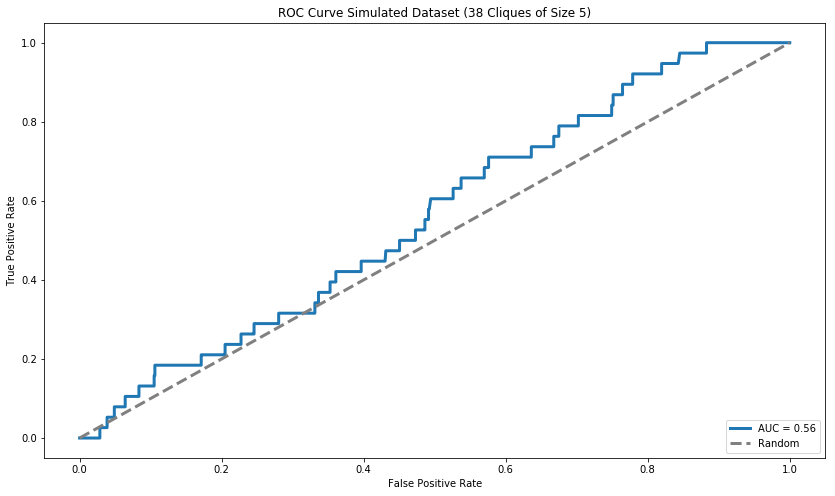

In [10]:
# ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
y = np.logical_or(y_train, y_test)
print (y.shape)
fpr, tpr, thresholds = roc_curve(y[:, 0], predictions.Prob_pos)
roc_auc = roc_auc_score(y[:, 0], predictions.Prob_pos)
fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, lw=3, label='AUC = {0:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Simulated Dataset (38 Cliques of Size 5)')
plt.legend(loc='lower right')
fig.savefig(model_dir + 'roc_curve.png')

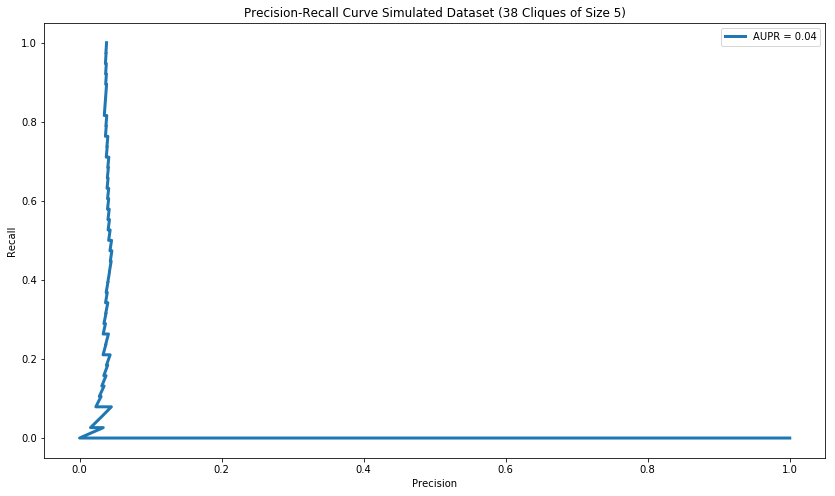

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import auc

pr, rec, thresholds = precision_recall_curve(y[:, 0], predictions.Prob_pos)
aupr = average_precision_score(y[:,0], predictions.Prob_pos)
fig = plt.figure(figsize=(14, 8))
plt.plot(pr, rec, lw=3, label='AUPR = {0:.2f}'.format(aupr))
#plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve Simulated Dataset (38 Cliques of Size 5)')
plt.legend()
fig.savefig(model_dir + 'prec_recall.png')

## Investigate New Model GCN Parameters

In [11]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = os.path.join(model_dir, "model.ckpt")
print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=True)


tensor_name:  beta1_power
0.31381
tensor_name:  beta2_power
0.989055
tensor_name:  embedding_0
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.00027301  0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
tensor_name:  mygcn/mygraphconvolution_1_vars/weights_0
[[-0.16212493 -0.24938951 -0.32727623 -0.42024824  0.30041566 -0.02815705
  -0.09890167  0.09078765 -0.19150847 -0.0678063  -0.18323191 -0.38914165
  -0.1161084  -0.15121168 -0.06650473 -0.06735332 -0.18620574  0.00925534
   0.02264159 -0.19767733]
 [-0.15729332 -0.11331576 -0.30708703 -0.02547364  0.01977869 -0.00594861
   0.33748987 -0.16508362 -0.24194832 

tensor_name:  mygcn/mygraphconvolution_3_vars/weights_0/Adam_1
[[ 0.00000001  0.00000001]
 [ 0.          0.        ]
 [ 0.00000001  0.00000001]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.00000003  0.00000003]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.00000012  0.00000012]
 [ 0.          0.        ]
 [ 0.00000001  0.00000001]
 [ 0.00000017  0.00000017]
 [ 0.          0.        ]
 [ 0.00000004  0.00000004]
 [ 0.          0.        ]
 [ 0.00000002  0.00000002]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.00000017  0.00000017]
 [ 0.00000041  0.00000041]
 [ 0.0000003   0.0000003 ]
 [ 0.          0.        ]
 [ 0.00000002  0.00000002]
 [ 0.00000003  0.00000003]
 [ 0.00000061  0.00000061]
 [ 0.00000009  0.00000009]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.00000001  0.00000001]
 [ 0.00000038  0.00000038]
 [ 0.          0.        ]
 [ 0.00000011  0.00000011]
 [ 0.00000011  0.00000011]
 [ 0.          0.  

In [12]:
def str_to_num(s):
    try:
        return int(s)
    except ValueError:
        return float(s)

def load_hyper_params(model_dir):
    file_name = os.path.join(model_dir, 'hyper_params.txt')
    with open(file_name, 'r') as f:
        args = {}
        for line in f.readlines():
            key, value = line.split('\t')
            args[key.strip()] = str_to_num(value.strip())
    print ("Hyper-Parameters read from {}".format(file_name))
    return args
args = load_hyper_params(model_dir)
args

Hyper-Parameters read from ../data/GCN/training/2018_01_22_17_10_15/hyper_params.txt


{'decay': 0.0005,
 'dropout': 0.5,
 'epochs': 10,
 'hidden1': 20,
 'hidden2': 40,
 'loss_mul': 1,
 'lr': 0.1,
 'support': 1}

In [13]:
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)

poly_support = args['support']
if poly_support > 1:
    support = chebyshev_polynomials(adj, poly_support)
    num_supports = 1 + poly_support
else:
    support = [preprocess_adj(adj)]
    num_supports = 1
print (len(support))
print ([s[2] for s in support])

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32,
                                      shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, 2)),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_dir)
ckpt.model_checkpoint_path

if ckpt and ckpt.model_checkpoint_path:
    with tf.Session() as sess:
        model = MYGCN(placeholders, input_dim=features.shape[1], logging=True)
        model.load(ckpt.model_checkpoint_path, sess)

1
[(1019, 1019)]
{'mygcn/mygraphconvolution_1_vars/weights_0/Adam:0': <tf.Variable 'mygcn/mygraphconvolution_1_vars/weights_0/Adam:0' shape=(24, 20) dtype=float32_ref>, 'mygcn_1/mygraphconvolution_5_vars/weights_0:0': <tf.Variable 'mygcn_1/mygraphconvolution_5_vars/weights_0:0' shape=(20, 40) dtype=float32_ref>, 'mygcn/mygraphconvolution_2_vars/weights_0/Adam_1:0': <tf.Variable 'mygcn/mygraphconvolution_2_vars/weights_0/Adam_1:0' shape=(20, 40) dtype=float32_ref>, 'mygcn_1/mygraphconvolution_4_vars/weights_0:0': <tf.Variable 'mygcn_1/mygraphconvolution_4_vars/weights_0:0' shape=(24, 20) dtype=float32_ref>, 'mygcn/mygraphconvolution_1_vars/weights_0:0': <tf.Variable 'mygcn/mygraphconvolution_1_vars/weights_0:0' shape=(24, 20) dtype=float32_ref>, 'mygcn/mygraphconvolution_1_vars/weights_0/Adam_1:0': <tf.Variable 'mygcn/mygraphconvolution_1_vars/weights_0/Adam_1:0' shape=(24, 20) dtype=float32_ref>, 'mygcn/mygraphconvolution_2_vars/weights_0:0': <tf.Variable 'mygcn/mygraphconvolution_2_va

NotFoundError: Key mygcn_1/mygraphconvolution_6_vars/weights_0:0 not found in checkpoint
	 [[Node: save_1/RestoreV2_11 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_11/tensor_names, save_1/RestoreV2_11/shape_and_slices)]]

Caused by op 'save_1/RestoreV2_11', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/roman/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/roman/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/roman/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/roman/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-2431f903c446>", line 36, in <module>
    model.load(ckpt.model_checkpoint_path, sess)
  File "/home/roman/PROJECTS/ppi/legionella/GCN/my_gcn.py", line 166, in load
    saver = tf.train.Saver(self.vars)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1139, in __init__
    self.build()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key mygcn_1/mygraphconvolution_6_vars/weights_0:0 not found in checkpoint
	 [[Node: save_1/RestoreV2_11 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_11/tensor_names, save_1/RestoreV2_11/shape_and_slices)]]


## Do the predictions have special properties?
I want to check the shortest path between predicted disease genes and true disease genes as well.
Further, I want to see them in a network.

In [ ]:
# build networkx graph with correct node names
G = nx.from_numpy_matrix(network)
#mapping = {i:node_names[i, 0] for i in range(node_names.shape[0])}
#nx.relabel_nodes(G, mapping, copy=False)

### Shortest Paths

In [ ]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_shortest_paths = nx.shortest_path_length(G)
sp_df = pd.DataFrame(dict(all_shortest_paths))

In [ ]:
# build views for label to label shortest paths and non-label to non-label
label_cond = sp_df.index.isin(predictions_for_knowns.index)
label_to_label = sp_df.loc[label_cond, label_cond]
nonlabel_to_nonlabel = sp_df.loc[~label_cond, ~label_cond]
label_to_nonlabel = sp_df.loc[~label_cond, label_cond]

In [ ]:
# plot the distributions
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 8, 1)

ltl = pd.Series(label_to_label.values.flatten()).dropna()
ntn = pd.Series(nonlabel_to_nonlabel.values.flatten()).dropna()
ltn = pd.Series(label_to_nonlabel.values.flatten()).dropna()
print (ltl.shape, ntn.shape, ltn.shape)
plt.hist(ltl, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection To Infection (mean {0:.2f})'.format(ltl.mean()))
plt.hist(ntn, bins=bins, alpha=.7, normed=True, color='gray',
         label='Non-Infection To Non-Infection (mean {0:.2f})'.format(ntn.mean()))
plt.hist(ltn, bins=bins, alpha=.3, normed=True, color='blue',
         label='Infection To Non-Infection (mean {0:.2f})'.format(ltn.mean()))
points = np.linspace(0, 8, 100)
plt.plot(points, mlab.normpdf(points, ltl.mean(), ltl.std()), color='red', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ntn.mean(), ntn.std()), color='gray', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ltn.mean(), ltn.std()), color='blue', alpha=0.5)
plt.legend()
plt.title('Histograms of Shortest Paths between Infection Genes and Non-Infection Genes')
plt.xlabel('Shortest Path Length')
plt.ylabel('Normalized Frequency')
fig.savefig(model_dir + '/path_length_distribution.png')

### Node Degree

In [ ]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_node_degrees = G.degree()
degree_df = pd.Series(dict(all_node_degrees))

# build views for label and non-label degrees
label_cond = degree_df.index.isin(predictions_for_knowns.index)
labels = degree_df[label_cond]
nonlabels = degree_df[~label_cond]
print (labels.shape, nonlabels.shape)

# plot histograms
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 50, 1)
plt.hist(labels, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection Genes (Median {})'.format(labels.median()))
plt.hist(nonlabels, bins=bins, alpha=.7, normed=True, color='gray',
         label='Other Genes (Median {})'.format(nonlabels.median()))
plt.legend()
plt.title('Histograms of Node Degree for Infection and Other Genes')
plt.xlabel('Node Degree')
plt.ylabel('Normalized Frequency')
fig.savefig(model_dir + 'node_degrees.png')

### Probability that Neighbor of Infection Gene is also Infection Gene

In [ ]:
# half because of symmetric matrix
num_of_neighbor_labels = label_to_label[label_to_label == 1].count().sum() / 2
prob_neighbor_label = (num_of_neighbor_labels / label_to_label.shape[0]) * 100
print ("Chance of label to have labeled neighbor: {0:.2f} %".format(prob_neighbor_label))

In [ ]:
num_label_nbs = []
num_nbs = []
for label in predictions.index:
    nbs = list(nx.all_neighbors(G, label))
    label_nbs = predictions_for_knowns.index.isin(nbs).sum()
    num_label_nbs.append(label_nbs)
    num_nbs.append(len(nbs))
num_label_nbs = np.array(num_label_nbs)
num_total_nbs = np.array(num_nbs)
print ("Number of labeled neighbors: {}".format(num_label_nbs.sum()))
print ("Number of neighbors total: {}".format(num_total_nbs.sum()))
freq = num_label_nbs.sum()/num_total_nbs.sum()
print ("Chance that neighbor is labeled: {0:.4f}".format(freq))

## Visualize the Filters

In [ ]:
flags = tf.app.flags
FLAGS = flags.FLAGS

flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 150, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 40, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.6, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 50, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
flags.DEFINE_bool('cheby', True, 'Using Chebyshev convolutions or not.')

In [ ]:
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)
support = chebyshev_polynomials(adj, 2)
print (len(support))
print ([s[2] for s in support])

In [ ]:
tf.reset_default_graph()
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(1+FLAGS.max_degree)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, 2)),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

weights_layer_0 = []
weights_layer_1 = []
with tf.Session() as sess:
    model = GCN(placeholders, input_dim=features.shape[1], logging=True)
    model.load(sess)
    for k in range(FLAGS.max_degree): # chebychev coefficients
        mat_name = 'gcn/graphconvolution_{}_vars/weights_{}:0'.format(1, k)
        weights_layer_0.append(model.vars[mat_name].eval())
        mat_name = 'gcn/graphconvolution_{}_vars/weights_{}:0'.format(2, k)
        weights_layer_1.append(model.vars[mat_name].eval())
    
    # predict for test set and catch activations in H_1, H_2
    feed_dict = construct_feed_dict(features=F,
                                    support=support,
                                    labels=y_train,
                                    labels_mask=train_mask,
                                    placeholders=placeholders
                                   )
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    #l = sess.run(model.loss, feed_dict=feed_dict)
    activation_0 = sess.run(model.activations[-2], feed_dict=feed_dict)
    activation_1 = sess.run(model.activations[-1], feed_dict=feed_dict)

## Plot Feature Importance

In [ ]:
def plot_weights_for_k(matrix, fname='kernel_activation'):
    fig = plt.figure(figsize=(14, 8))
    num_rows, num_cols = bestSplit(matrix.shape[1])
    for i in range(matrix.shape[1]):
        plt.subplot(num_rows, num_cols, i+1)
        plt.bar(np.arange(0, matrix.shape[0]), matrix[:, i])
    fig.savefig('{}/{}.png'.format(model_dir, fname))

weights_l0_sum = np.sum(weights_layer_0, axis=0)
print (weights_l0_sum.shape)
plot_weights_for_k(weights_l0_sum, 'filters_layer0_k0')

In [ ]:
weights_l1_sum = np.sum(weights_layer_1, axis=0)
plot_weights_for_k(weights_l1_sum, 'filters_layer1_sum')

## Visualize the activations
Next, I want to see if the activations cluster together, that is if the output from each of the layers is embedded nicely.

In [ ]:
predictions.head()

In [ ]:
preds_and_labels = labels_df.join(predictions)
pos_classified = preds_and_labels.Prob_pos >= CLASSIFICATION_THRESHOLD

# set the colors according to classes
preds_and_labels['color'] = 'gray'
preds_and_labels.loc[pos_classified, 'color'] = 'red'
preds_and_labels.loc[~preds_and_labels.label & pos_classified, 'color'] = 'green'
preds_and_labels.groupby('color').count()

In [ ]:
H_1_2d = TSNE(n_components=2).fit_transform(activation_0)

In [ ]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_1_2d[:, 0], H_1_2d[:, 1], c=preds_and_labels.color, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot: First Hidden Layer')

# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
plt.legend(handles=[inf_genes, pred_genes])

# save
fig.savefig(model_dir + '/tsne_H1.png', dpi=300)

In [ ]:
H_2_2d = TSNE(n_components=2).fit_transform(activation_1)

In [ ]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_2_2d[:, 0], H_2_2d[:, 1], c=preds_and_labels.color, alpha=.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot: Second Hidden Layer')
# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
plt.legend(handles=[inf_genes, pred_genes])
# save
fig.savefig(model_dir + '/tsne_H2.png', dpi=300)

In [ ]:
H_1_pca = PCA(n_components=2).fit_transform(activation_0)
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_1_pca[:, 0], H_1_pca[:, 1], c=preds_and_labels.color, alpha=.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot: First Hidden Layer')
# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
plt.legend(handles=[inf_genes, pred_genes])
# save
fig.savefig(model_dir + '/pca_H1.png', dpi=300)

In [ ]:
H_2_pca = PCA(n_components=2).fit_transform(activation_1)
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_2_pca[:, 0], H_2_pca[:, 1], c=preds_and_labels.color, alpha=.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot: Second Hidden Layer')
# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
plt.legend(handles=[inf_genes, pred_genes])
# save
fig.savefig(model_dir + '/pca_H2.png', dpi=300)

## Correlation with other methods
I will now try to see how similar my performance is to NetRank and PageRank.

In [ ]:
netrank_scores = pd.DataFrame.from_csv('../data/pagerank/netrank_scores.txt', header=0, sep='\t')
netrank_scores.rename(columns={'Rank': 'NetRank_Rank'})
predictions.sort_values('Prob_pos', ascending=False, inplace=True)
predictions['GCN_Rank'] = np.arange(1, predictions.shape[0]+1)
print ("Correlation Rank & Prob: {}".format(predictions.Prob_pos.corr(predictions.GCN_Rank)))

In [ ]:
netrank_with_predictions = predictions.join(netrank_scores, how='inner')
fig = plt.figure(figsize=(14, 14))
plt.scatter(netrank_with_predictions.GCN_Rank, netrank_with_predictions.Rank, color='gray')
lin = np.arange(1, netrank_with_predictions.shape[0]+1)
plt.plot(lin, lin, '--', color='black')

print ("Correlation between NetRank and GCN: {}".format(netrank_with_predictions.Rank.corr(netrank_with_predictions.GCN_Rank)))

In [ ]:
netrank_scores.head()